In [1]:
import sqlite3
import sys

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from shapely import affinity
import contextily as cx

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("..")

In [5]:
from src.trajectory import Trajectory, point_to_bbox

# Read data

### Export data from sqlite DB

In [48]:
db_path = "../data/raw/rdb1/trajectories_rdb1_v3.sqlite"

In [49]:
con = sqlite3.connect(db_path)

In [50]:
cursor = con.cursor()

Tables in the sqlite DB:

In [51]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [r[0] for r in cursor.fetchall()]
print(tables)

['rdb1_1', 'rdb1_2', 'rdb1_3', 'rdb1_4', 'rdb1_5', 'rdb1_6', 'rdb1_7', 'rdb1_8', 'rdb1_9', 'rdb1_10', 'rdb1_11', 'rdb1_12', 'rdb1_13', 'rdb1_14', 'rdb1_15', 'rdb1_16', 'rdb1_17', 'rdb1_18', 'rdb1_19', 'rdb1_20', 'rdb1_21', 'rdb1_22', 'rdb1_23', 'rdb1_24', 'rdb1_25', 'rdb1_26', 'rdb1_27', 'rdb1_28', 'rdb1_29', 'rdb1_30', 'rdb1_31', 'rdb1_32', 'rdb1_33', 'rdb1_34', 'rdb1_35', 'rdb1_36', 'rdb1_37', 'rdb1_38', 'rdb1_39', 'rdb1_40', 'rdb1_41', 'rdb1_42', 'rdb1_43', 'rdb1_44', 'rdb1_45', 'rdb1_46', 'rdb1_47', 'rdb1_48', 'rdb1_49', 'rdb1_50', 'rdb1_51', 'rdb1_52', 'rdb1_53', 'rdb1_54', 'rdb1_55', 'rdb1_56', 'rdb1_57', 'rdb1_58', 'rdb1_59', 'rdb1_60', 'rdb1_61', 'rdb1_62', 'rdb1_63', 'rdb1_64', 'rdb1_65', 'rdb1_66', 'rdb1_67', 'rdb1_68', 'rdb1_69', 'rdb1_70', 'rdb1_71', 'rdb1_72', 'rdb1_73', 'rdb1_74', 'rdb1_75', 'rdb1_76', 'rdb1_77', 'rdb1_78', 'rdb1_79', 'rdb1_80', 'rdb1_81', 'rdb1_82', 'rdb1_83', 'rdb1_84', 'rdb1_85', 'rdb1_86', 'rdb1_87', 'rdb1_88', 'rdb1_89', 'rdb1_90', 'rdb1_91', 'rdb1_9

In [52]:
pd.read_sql('SELECT * FROM rdb1_1', con)

,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,TRAILER_ID
0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,NaN
1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,NaN
2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,NaN
3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,NaN
4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218506,218507,560.593367,356,619361.69,5809166.33,3.540785,4.86,0.1177,0.0042,0.1176,Car,1.8747,5.4149,NaN
218507,218508,560.626733,356,619361.54,5809166.27,3.542285,4.86,0.1177,0.0042,0.1176,Car,1.8747,5.4149,NaN
218508,218509,560.660100,356,619361.39,5809166.20,3.543685,4.86,0.1177,0.0042,0.1176,Car,1.8747,5.4149,NaN
218509,218510,560.693467,356,619361.24,5809166.14,3.544885,4.86,0.1177,0.0042,0.1176,Car,1.8747,5.4149,NaN


In [53]:
df_list = list()
for t in tables:
    df_t = pd.read_sql(f'SELECT * FROM {t:s}', con)
    df_t["table"] = t
    df_list.append(df_t)
df = pd.concat(df_list)

In [54]:
del df["TRAILER_ID"] 

In [55]:
df = df.reset_index()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19174608 entries, 0 to 19174607
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   index      int64  
 1   ID         int64  
 2   TIMESTAMP  float64
 3   OBJID      int64  
 4   UTM_X      float64
 5   UTM_Y      float64
 6   UTM_ANGLE  float64
 7   V          float64
 8   ACC        float64
 9   ACC_LAT    float64
 10  ACC_TAN    float64
 11  CLASS      object 
 12  WIDTH      float64
 13  LENGTH     float64
 14  table      object 
dtypes: float64(10), int64(3), object(2)
memory usage: 2.1+ GB


In [15]:
output_path = "../data/raw/rdb1.parquet"

In [57]:
df.to_parquet(output_path)

### Read prepared data

In [ ]:
df = pd.read_parquet(output_path)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19174608 entries, 0 to 19174607
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   index      int64  
 1   ID         int64  
 2   TIMESTAMP  float64
 3   OBJID      int64  
 4   UTM_X      float64
 5   UTM_Y      float64
 6   UTM_ANGLE  float64
 7   V          float64
 8   ACC        float64
 9   ACC_LAT    float64
 10  ACC_TAN    float64
 11  CLASS      object 
 12  WIDTH      float64
 13  LENGTH     float64
 14  table      object 
dtypes: float64(10), int64(3), object(2)
memory usage: 2.1+ GB


In [18]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217


# Preprocessing

In [19]:
df["_V_kmh"] = df["V"]*3.6

# Explore data

In [20]:
print("Number of traffic participants:", df["OBJID"].nunique())

Number of traffic participants: 32873


In [21]:
print(df.groupby("OBJID").agg({"CLASS": "first"})["CLASS"].value_counts())

Car               26879
Medium Vehicle     2630
Pedestrian          963
Bicycle             831
Bus                 551
Trailer             529
Heavy Vehicle       347
Motorcycle          143
Name: CLASS, dtype: int64


## Sample rate

In [22]:
obj1_df = df.query("OBJID==1").sort_values("TIMESTAMP")

In [23]:
obj1_df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,_V_kmh
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,17.064
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,17.100
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,17.100
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,17.100
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,17.136


Text(0.5, 0, 'time [s]')

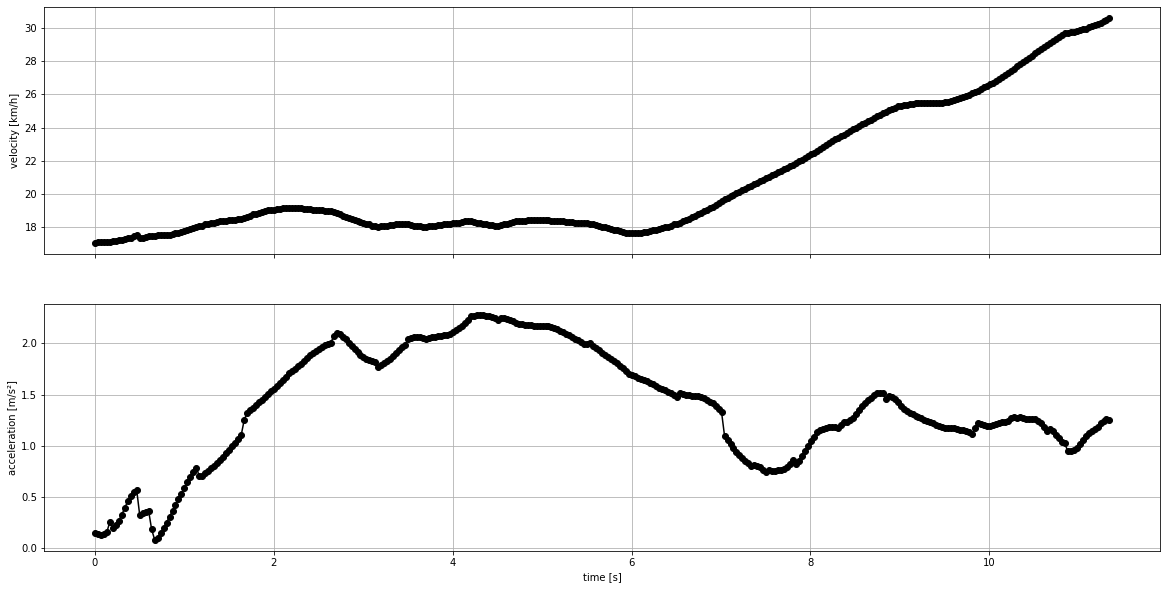

In [24]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
axv, axa = axs
axv.plot(obj1_df["TIMESTAMP"], obj1_df["_V_kmh"], "ko-")
axa.plot(obj1_df["TIMESTAMP"], obj1_df["ACC"], "ko-")

axv.set_ylabel("velocity [km/h]")
axv.grid()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")

In [25]:
delta_t_ms = np.diff(obj1_df["TIMESTAMP"].values*1000)

In [26]:
delta_t_ms.min(), delta_t_ms.max()

(33.36599999999817, 33.36700000000019)

In [27]:
dr = stats.describe(delta_t_ms)
dr

DescribeResult(nobs=340, minmax=(33.36599999999817, 33.36700000000019), mean=33.36666764705882, variance=2.225490195580104e-07, skewness=-0.7117913418411341, kurtosis=-1.4933530856698929)

Compute stats on sampling frequency derived from temporal differences between samples:

In [28]:
def mean_sample_frequency(values):
    return 1/np.diff(values).mean()

In [29]:
df.groupby("OBJID").agg({"TIMESTAMP": mean_sample_frequency}).rename(columns={'TIMESTAMP': 'frequency'}).describe()

,frequency
count,32873.000000
mean,29.970030
std,0.000003
min,29.969910
25%,29.970030
50%,29.970030
75%,29.970030
max,29.970090


Looks like the objects are sampled with **30 Hz**.

## Velocity and acceleration distributions per class

In [30]:
df["_V_kmh"] = df["V"]*3.6

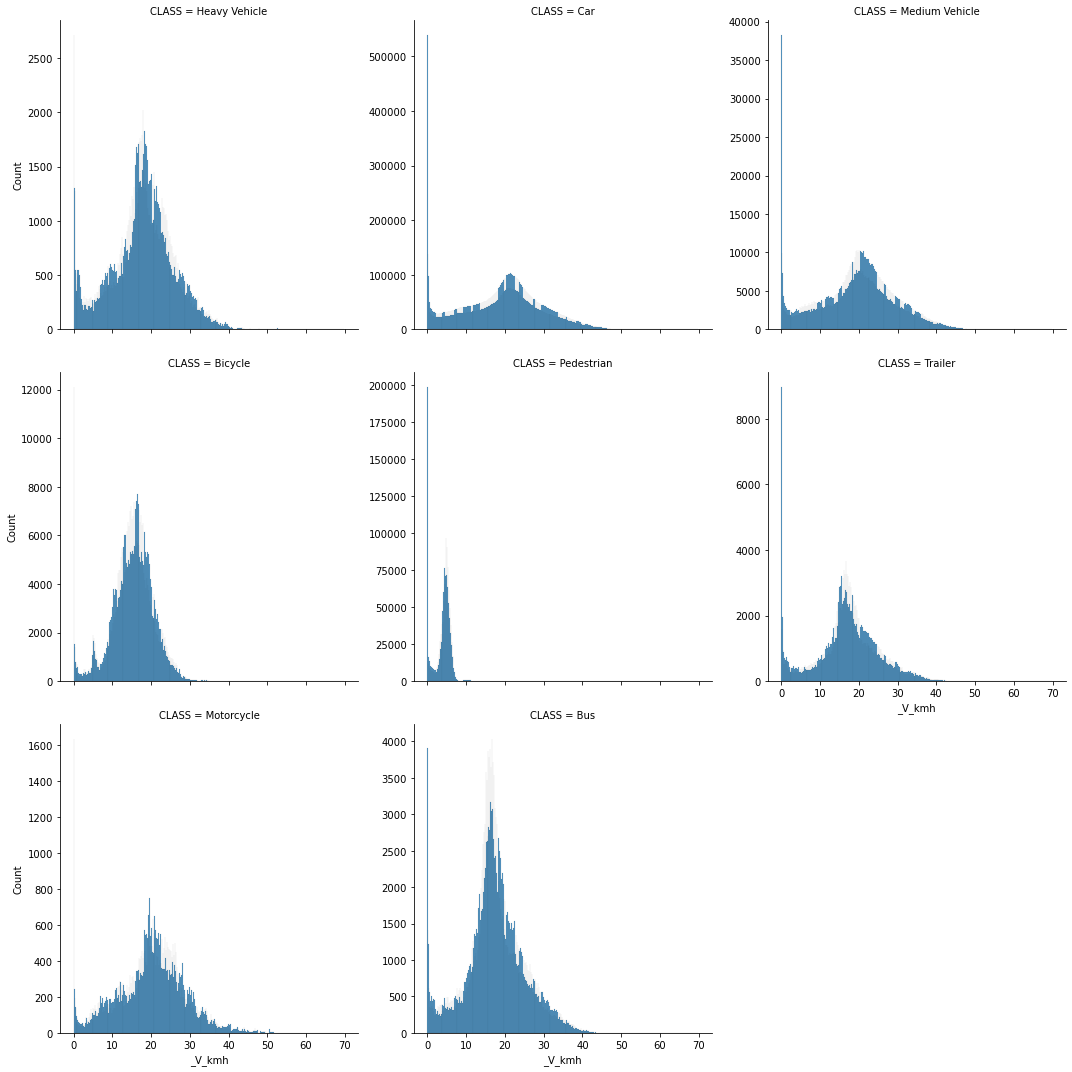

In [31]:
fg = sns.displot(df, x="_V_kmh", col="CLASS", col_wrap=3, facet_kws=dict(sharey=False))

In [32]:
df["ACC_TAN"].describe()

count    1.917461e+07
mean     1.610375e-01
std      7.595011e-01
min     -7.998650e+01
25%     -1.668000e-01
50%      9.240000e-02
75%      5.987000e-01
max      8.160790e+01
Name: ACC_TAN, dtype: float64

Text(0.5, 0.98, 'Cumulative distribution of acceleration samples')

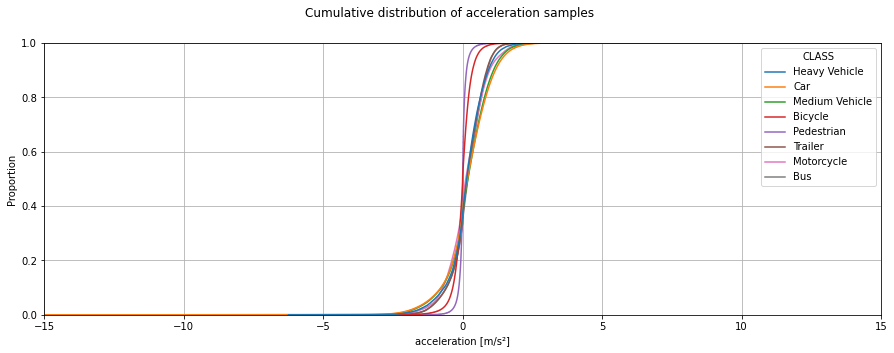

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.ecdfplot(df, x="ACC_TAN", hue="CLASS", ax=ax)
ax.set_xlim(-15, 15)
ax.set_xlabel("acceleration [m/s²]")
ax.grid()
fig.suptitle("Cumulative distribution of acceleration samples")

## Braking maneuvers

Get object IDs of trajectories with high decelleration

In [34]:
ids = df[df['ACC_TAN'].between(-15, -7)]["OBJID"].unique()
print(f"Found {len(ids)} objects!")

Found 21 objects!


Text(0.5, 0, 'time [s]')

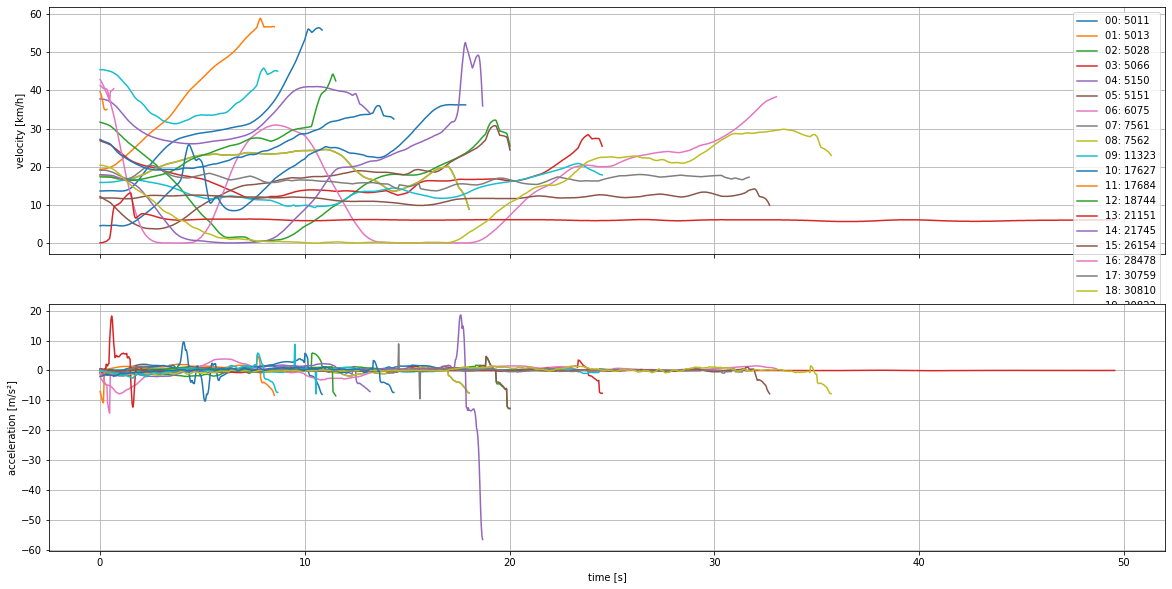

In [35]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
axv, axa = axs

for i, objid in enumerate(ids):
    obj_df = df.query(f"OBJID=={objid}").sort_values("TIMESTAMP")
    
    obj_df["_t"] = obj_df["TIMESTAMP"] - obj_df["TIMESTAMP"].min()
    
    axv.plot(obj_df["_t"], obj_df["_V_kmh"], label=f"{i:02d}: {objid:03d}")
    axa.plot(obj_df["_t"], obj_df["ACC_TAN"])

axv.set_ylabel("velocity [km/h]")
axv.grid()
axv.legend()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")

In [36]:
obj_df = df.query(f"OBJID=={ids[5]}").sort_values("TIMESTAMP")

In [37]:
obj_df

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,_V_kmh
3432569,104607,104608,402.402000,5151,619289.23,5809124.31,0.692885,3.39,1.1179,0.0801,-1.1150,Bus,3.1727,12.076,12.204
3432570,104608,104609,402.435367,5151,619289.31,5809124.38,0.693885,3.36,1.2091,0.0844,-1.2061,Bus,3.1727,12.076,12.096
3432571,104609,104610,402.468733,5151,619289.40,5809124.46,0.694785,3.33,1.2669,0.0867,-1.2640,Bus,3.1727,12.076,11.988
3432572,104610,104611,402.502100,5151,619289.49,5809124.54,0.695785,3.30,1.2967,0.0876,-1.2938,Bus,3.1727,12.076,11.880
3432573,104611,104612,402.535467,5151,619289.58,5809124.62,0.696685,3.26,1.3021,0.0867,-1.2993,Bus,3.1727,12.076,11.736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3433165,105203,105204,422.288533,5151,619289.60,5809184.10,2.061985,7.63,12.1343,0.6667,-12.1160,Bus,3.1727,12.076,27.468
3433166,105204,105205,422.321900,5151,619289.55,5809184.20,2.061985,7.43,12.4883,0.6461,-12.4716,Bus,3.1727,12.076,26.748
3433167,105205,105206,422.355267,5151,619289.50,5809184.31,2.061985,7.21,12.7143,0.6267,-12.6988,Bus,3.1727,12.076,25.956
3433168,105206,105207,422.388633,5151,619289.44,5809184.41,2.061985,6.99,12.7892,0.6079,-12.7748,Bus,3.1727,12.076,25.164


In [38]:
trajectory = Trajectory(obj_df["TIMESTAMP"], obj_df["UTM_X"], obj_df["UTM_Y"], obj_df["UTM_ANGLE"], width=obj_df["WIDTH"].iloc[0], length=obj_df["LENGTH"].iloc[0])

In [39]:
trajectory.projection

'EPSG:25832'

In [40]:
traj_gdf = trajectory.to_geopandas(as_bbox=False)

In [41]:
traj_gdf.head()

,t,x,y,theta,geometry
3432569,402.402000,619289.23,5809124.31,0.692885,POINT (619289.230 5809124.310)
3432570,402.435367,619289.31,5809124.38,0.693885,POINT (619289.310 5809124.380)
3432571,402.468733,619289.40,5809124.46,0.694785,POINT (619289.400 5809124.460)
3432572,402.502100,619289.49,5809124.54,0.695785,POINT (619289.490 5809124.540)
3432573,402.535467,619289.58,5809124.62,0.696685,POINT (619289.580 5809124.620)


In [42]:
traj_gdf.crs.to_string()

'EPSG:25832'

In [43]:
# traj_gdf = traj_gdf.to_crs("EPSG:4326")

In [44]:
traj_gdf.crs.to_string()

'EPSG:25832'

C:\Users\kopyt\anaconda3\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


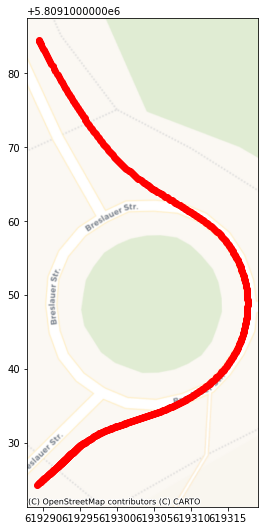

In [45]:
ax = traj_gdf.plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=traj_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")

In [46]:
traj_gdf.head()

,t,x,y,theta,geometry
3432569,402.402000,619289.23,5809124.31,0.692885,POINT (619289.230 5809124.310)
3432570,402.435367,619289.31,5809124.38,0.693885,POINT (619289.310 5809124.380)
3432571,402.468733,619289.40,5809124.46,0.694785,POINT (619289.400 5809124.460)
3432572,402.502100,619289.49,5809124.54,0.695785,POINT (619289.490 5809124.540)
3432573,402.535467,619289.58,5809124.62,0.696685,POINT (619289.580 5809124.620)


Text(0.5, 0, 'time [s]')

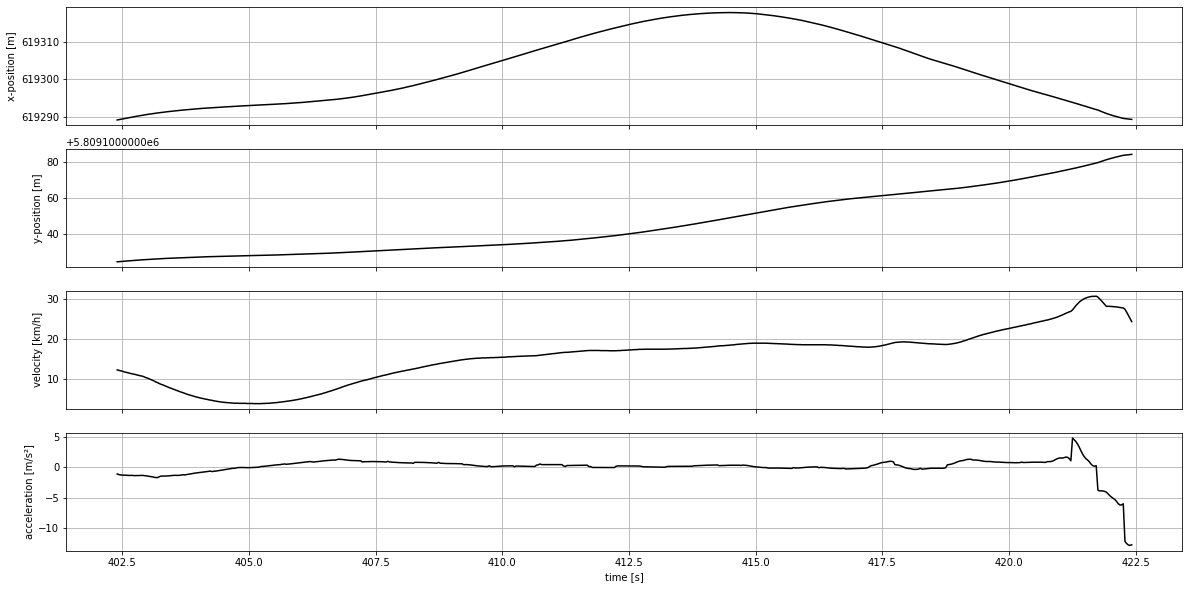

In [47]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 10), sharex=True)

axx, axy, axv, axa = axs

axx.plot(obj_df["TIMESTAMP"], obj_df["UTM_X"], "k-")
axy.plot(obj_df["TIMESTAMP"], obj_df["UTM_Y"], "k-")

axv.plot(obj_df["TIMESTAMP"], obj_df["_V_kmh"], "k-")
axa.plot(obj_df["TIMESTAMP"], obj_df["ACC_TAN"], "k-")

axx.set_ylabel("x-position [m]")
axx.grid()

axy.set_ylabel("y-position [m]")
axy.grid()

axv.set_ylabel("velocity [km/h]")
axv.grid()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")